<Body>   
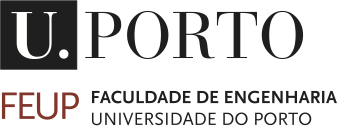   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Data preprocessing

In [42]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

#split df into train and test
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [43]:
#print the characteristics of the dataframes
print('Train shape: ', df_train.shape)
print('Test shape: ', df_test.shape)

Train shape:  (227845, 31)
Test shape:  (56962, 31)


In [44]:
class FraudDataset(Dataset):
 
  def __init__(self, dataframe, fraud = True):
    scaler = StandardScaler()
    df = dataframe
    if fraud:
      df = df[df['Class'] == 1]
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values
    #y = np.reshape(y, (1,-1))
    
    # Standardize data
    #x = scaler.fit_transform(x)
    #y = scaler.fit_transform(y)

    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)

    self.features = x.shape[1]
  def __len__(self):
    return len(self.x_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx], self.y_data[idx]

creditData = FraudDataset(df_train, fraud= True)
creditDataTest = FraudDataset(df_test, fraud= True)

In [45]:
train_dataloader = DataLoader(creditData, batch_size=64, drop_last=True)
test_dataloader = DataLoader(creditDataTest, batch_size=64, drop_last=True)

## Conditional Generative Adversarial Network

### Architecture

In [46]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
           nn.Linear(latent_dim, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(512, 256),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(256, 128),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(128, 64),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(64, 32),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(32, 16),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(16, nr_features)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [47]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(nr_features, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(512, 256),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(256, 128),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(128, 64),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(64, 32),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(32, 16),
        nn.ReLU(inplace = True),
        nn.Dropout2d(0.2),
    
        nn.Linear(16, 1)
        )
            
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [48]:
#define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

latent_dim = 7
nr_features = 30

#create optimizer for the generator
generator = Generator(latent_dim, nr_features).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

#create optimizer for the descriminator
discriminator = Discriminator(nr_features)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

print(f"Using {device} device")


Using cpu device


In [49]:
print('\t\t\tGenerator')
summary(generator, input_size=(latent_dim,))

			Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]           8,192
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
         Dropout2d-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
         Dropout2d-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
        Dropout2d-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
        Dropout2d-14      

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [50]:
print('\t\t\tDiscriminator')
summary(discriminator, input_size=(nr_features,))

			Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]          31,744
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 512]         524,800
              ReLU-4                  [-1, 512]               0
         Dropout2d-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
         Dropout2d-8                  [-1, 256]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
        Dropout2d-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
        Dropout2d-14  

####  Loss Function + Device + Reset Gradients Funct.

In [51]:
criterion = nn.BCELoss()

In [52]:
def train_generator(opt_g, cur_batch_size, criterion):
    # Clear generator gradients
    opt_g.zero_grad()
    
   
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)

    g_loss.backward()
    opt_g.step()
    
    return g_loss

In [53]:
def train_discriminator(real_data, opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
   
    #real_labels = df_fraud['Class'].to_numpy() #sendo que estamos 
    
    real_labels = torch.ones((cur_batch_size), device=device)
    
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    fake_labels = torch.zeros((cur_batch_size),  device = device)
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds.detach(), fake_labels)
    
    loss = d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [54]:
class GAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.0002
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = FraudDataset(train_df, fraud= True)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_dim=latent_size, nr_features=self.dataset.features).to(device)
        self.D = Discriminator(nr_features=self.dataset.features).to(device)
        self.latent_size = latent_size

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=0.0002)
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=0.0002)

    def train(self,real_data, cur_batch_size, epochs=1000):
        losses_gen = []
        losses_dis = []
        for epoch in range(epochs):
            
            for i, (real_data, _)  in enumerate(self.dataloader):
                cur_batch_size = real_data.shape[0] #check this
                # Train discriminator
                d_error = train_discriminator(real_data, discriminator_optimizer, cur_batch_size)
                #print(f'Discriminator loss {dis_loss:.3f}')

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train generator every n_critic iterations
                if i % self.n_critic == 0:
                    g_error = train_generator(generator_optimizer, cur_batch_size, criterion)
                    #generated_data = generated_data_batch if generated_data is None else torch.cat((generated_data, generated_data_batch))

                    #print(f'Generator loss: {gen_loss:.3f}')
                

                losses_gen.append(g_error)
                losses_dis.append(d_error)

            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f} \n'
                .format(epoch, epoch, i+1, len(self.dataloader), d_error.item(), g_error.item()))
            
        return losses_gen, losses_dis



    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(device)
            gen = self.G(z)
            return gen.cpu().numpy()

In [55]:
gan = GAN(df_train)

In [56]:
losses_gen, losses_dis = gan.train(df_train, 64, epochs=200)

Epoch [0/0], Step [7/7], d_loss: 0.8407, g_loss: 0.5964 

Epoch [1/1], Step [7/7], d_loss: 2.5578, g_loss: 0.5969 



Epoch [2/2], Step [7/7], d_loss: 1.3798, g_loss: 0.5947 

Epoch [3/3], Step [7/7], d_loss: 0.7995, g_loss: 0.5929 

Epoch [4/4], Step [7/7], d_loss: 0.8215, g_loss: 0.5903 

Epoch [5/5], Step [7/7], d_loss: 0.8126, g_loss: 0.5902 

Epoch [6/6], Step [7/7], d_loss: 0.8052, g_loss: 0.5891 

Epoch [7/7], Step [7/7], d_loss: 0.8127, g_loss: 0.5901 

Epoch [8/8], Step [7/7], d_loss: 0.8045, g_loss: 0.5903 

Epoch [9/9], Step [7/7], d_loss: 0.8126, g_loss: 0.5863 

Epoch [10/10], Step [7/7], d_loss: 0.8042, g_loss: 0.5877 

Epoch [11/11], Step [7/7], d_loss: 0.8098, g_loss: 0.5841 

Epoch [12/12], Step [7/7], d_loss: 0.8187, g_loss: 0.5833 

Epoch [13/13], Step [7/7], d_loss: 0.8121, g_loss: 0.5855 

Epoch [14/14], Step [7/7], d_loss: 0.8148, g_loss: 0.5837 

Epoch [15/15], Step [7/7], d_loss: 0.8145, g_loss: 0.5852 

Epoch [16/16], Step [7/7], d_loss: 0.8235, g_loss: 0.5820 

Epoch [17/17], Step [7/7], d_loss: 0.8214, g_loss: 0.5842 

Epoch [18/18], Step [7/7], d_loss: 0.8177, g_loss: 0.585

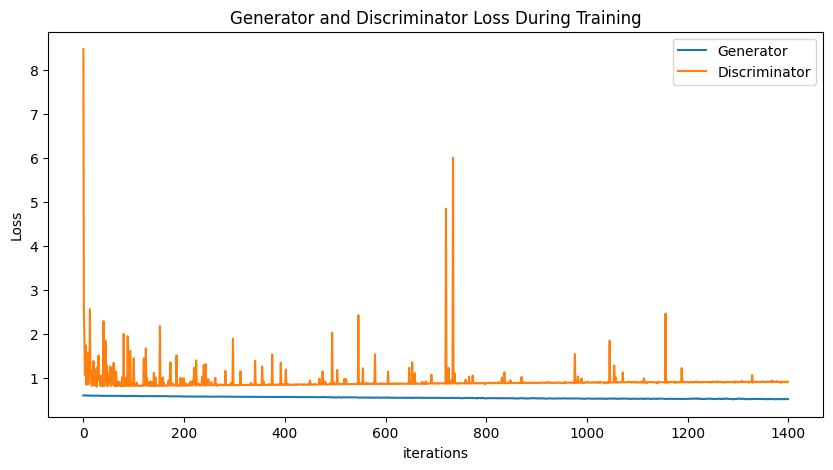

In [57]:
def plot_losses(losses_gen, losses_dis):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")

    #convert losses into numpy
    losses_gen = [i.detach().numpy() for i in losses_gen]
    losses_dis = [i.detach().numpy() for i in losses_dis]
    plt.plot(losses_gen,label="Generator")
    plt.plot(losses_dis,label="Discriminator")
    plt.xlabel("iterations") #Epochs * Steps
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses(losses_gen, losses_dis)

In [58]:
sample_number = df_train[df_train['Class'] == 0].shape[0]
gan_samples = gan.sample(sample_number)
samples_test = np.append(gan_samples, np.ones((sample_number, 1)), axis=1)
wgan_df = pd.DataFrame(samples_test, columns=df_train.columns)
#concat wgan_df with df_train
df_concat = pd.concat([df_train, wgan_df], ignore_index=True)

KeyboardInterrupt: 

In [ ]:
df_concat['Class'].value_counts()

Class
1.0    227845
0.0    227451
Name: count, dtype: int64

### Model evaluation

In [ ]:
class Model(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(nr_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [ ]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 64
        self.dataset = FraudDataset(train_df, fraud = False)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(nr_features=self.dataset.features).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(device)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1
        ConfusionMatrixDisplay.from_predictions(test_df['Class'].values, labels, normalize='true')
        print(classification_report(test_df['Class'].values, labels))

In [ ]:
fw_model = FraudModel(df_concat)
fw_model.train(epochs=100)
fw_model.evaluate(df_test, confidence=0.90)

KeyboardInterrupt: 